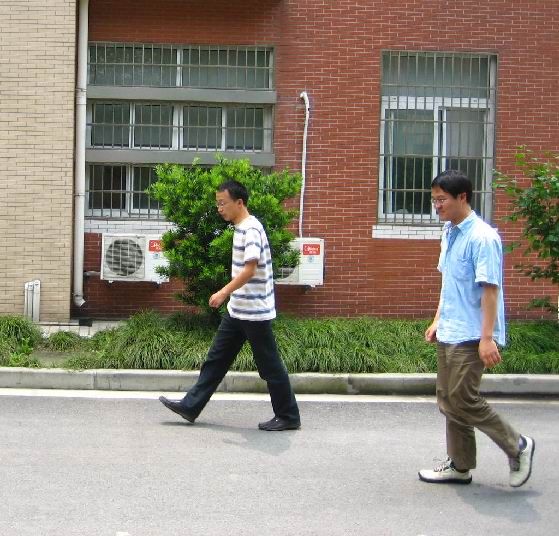

In [4]:
from PIL import Image
Image.open('/kqi/input/training/PNGimagesのデータセット番号/FudanPed00001.png')

In [5]:
cd PythonAPI

[Errno 2] No such file or directory: 'PythonAPI'
/kqi/output


In [6]:
pwd

'/kqi/output'

In [7]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImagesを入れたデータセット番号"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasksを入れたデータセット番号"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImagesを入れたデータセット番号", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasksを入れたデータセット番号", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
dataset = PennFudanDataset('/kqi/input/training/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F297053E5C0>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
 
def get_instance_segmentation_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [30]:
pwd

'/kqi/output/cocoapi/PythonAPI'

In [34]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import matplotlib

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [36]:
# use our dataset and defined transformations
dataset = PennFudanDataset('/kqi/input/training', get_transform(train=True))
dataset_test = PennFudanDataset('/kqi/input/training', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160M/160M [00:06<00:00, 26.7MB/s]


In [38]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:39  lr: 0.000090  loss: 1.2410 (1.2410)  loss_classifier: 1.0216 (1.0216)  loss_box_reg: 0.2010 (0.2010)  loss_objectness: 0.0109 (0.0109)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 1.6591  data: 0.2683  max mem: 3078
Epoch: [0]  [10/60]  eta: 0:00:18  lr: 0.000936  loss: 0.9589 (0.9104)  loss_classifier: 0.7202 (0.6352)  loss_box_reg: 0.2155 (0.2459)  loss_objectness: 0.0149 (0.0183)  loss_rpn_box_reg: 0.0076 (0.0111)  time: 0.3710  data: 0.0317  max mem: 3317
Epoch: [0]  [20/60]  eta: 0:00:12  lr: 0.001783  loss: 0.4930 (0.7026)  loss_classifier: 0.2761 (0.4414)  loss_box_reg: 0.2155 (0.2309)  loss_objectness: 0.0114 (0.0177)  loss_rpn_box_reg: 0.0110 (0.0125)  time: 0.2415  data: 0.0065  max mem: 3317
Epoch: [0]  [30/60]  eta: 0:00:08  lr: 0.002629  loss: 0.3255 (0.5543)  loss_classifier: 0.0968 (0.3207)  loss_box_reg: 0.1884 (0.2064)  loss_objectness: 0.0085 (0.0153)  loss_rpn_box_reg: 0.0103 (0.0119)  time: 0.2312  data: 0.0047  max mem: 3317
Epoch: [

In [44]:
# pick one image from the test set
img, _ = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

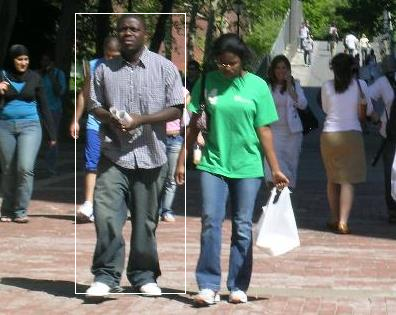

In [45]:
from PIL import ImageDraw

im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

draw = ImageDraw.Draw(im)
draw.rectangle(prediction[0]['boxes'][0].cpu().numpy())

im